# **Import Library**

Pada bagian ini dilakukan import library yang digunakan untuk proses data processing, modeling, dan evaluasi.

In [59]:
!pip install scikit-surprise
!pip install numpy==1.23.5

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from IPython.display import display
from sklearn.neighbors import NearestNeighbors

# **Load Dataset**

Pada tahap ini, tiga file dataset dimuat ke dalam DataFrame. File yang dimuat adalah `BX-Books.csv`, `BX-Book-Ratings.csv`, dan `BX-Users.csv`, masing-masing berisi data terkait buku, rating buku oleh pengguna, dan informasi pengguna. Karena dataset menggunakan pemisah tanda titik koma (`;`), parameter `sep` diset ke `;`. Untuk menghindari kesalahan dalam pembacaan karakter spesial seperti aksen atau simbol asing, digunakan encoding `latin-1`.

Dalam proses ini juga diantisipasi adanya baris rusak atau tidak sesuai format dengan menambahkan parameter `on_bad_lines='skip'`, sehingga baris yang bermasalah akan dilewati. Selain itu, engine pembacaan diset menjadi `python` untuk memastikan parsing data lebih toleran terhadap ketidakteraturan dalam format CSV.

In [61]:
# Gunakan 'engine=python' untuk toleransi error parsing CSV
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip', engine='python')
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1', on_bad_lines='skip', engine='python')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1', on_bad_lines='skip', engine='python')

# **Data Understanding**

Pada tahap ini dilakukan proses pembersihan (data cleaning) untuk memastikan kualitas data yang akan digunakan pada model.

In [62]:
# Cleaning Books
books.dropna(how='all', inplace=True)

Data pada `BX-Books.csv` dibersihkan dengan menghapus seluruh baris yang kosong menggunakan `dropna(how='all')`. Langkah ini diperlukan untuk menghilangkan data yang tidak memiliki informasi sama sekali.

In [63]:
# Cleaning Ratings
ratings = ratings[ratings['Book-Rating'] > 0]

Data pada `BX-Book-Ratings.csv` difilter untuk hanya mempertahankan rating dengan nilai lebih dari 0. Rating dengan nilai 0 dianggap tidak memberikan penilaian aktual terhadap buku, sehingga tidak relevan untuk model rekomendasi.

In [64]:
# Cleaning Users
users = users[(users['Age'].fillna(0) >= 5) & (users['Age'].fillna(0) <= 100)]

Data pada `BX-Users.csv` difilter berdasarkan usia pengguna. Rentang usia valid ditetapkan antara 5 hingga 100 tahun. Nilai usia yang kosong (`NaN`) diisi sementara dengan 0 menggunakan `fillna(0)`, dan hanya usia yang berada dalam rentang tersebut yang dipertahankan. Langkah ini dilakukan untuk menghindari noise yang mungkin disebabkan oleh data usia yang tidak logis atau hilang.


In [65]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

Selain itu, pengaturan tampilan DataFrame juga diubah untuk memperluas batas kolom (`display.max_colwidth`) dan lebar tampilan (`display.width`), sehingga tabel data yang ditampilkan menjadi lebih mudah dibaca tanpa terpotong.

### **Books Dataset**

In [66]:
print("=== Info Dataset Books ===")
print(books.info())
print(books.describe())
display(books[['ISBN', 'Book-Title', 'Book-Author', 'Publisher']].head())
print(f"Jumlah record di Books: {books.shape[0]}")

=== Info Dataset Books ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270494 entries, 0 to 270493
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 270494 non-null  object
 1   Book-Title           270494 non-null  object
 2   Book-Author          270492 non-null  object
 3   Year-Of-Publication  270494 non-null  int64 
 4   Publisher            270492 non-null  object
 5   Image-URL-S          270494 non-null  object
 6   Image-URL-M          270494 non-null  object
 7   Image-URL-L          270494 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.5+ MB
None
       Year-Of-Publication
count        270494.000000
mean           1959.705372
std             258.205839
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000


,ISBN,Book-Title,Book-Author,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,W. W. Norton & Company


Jumlah record di Books: 270494




Eksplorasi awal dilakukan untuk memahami struktur dataset `books`. Dataset ini memiliki 270,494 baris dan 8 kolom, dengan mayoritas tipe data berupa teks (`object`) dan satu kolom numerik (`Year-Of-Publication`). Statistik deskriptif menunjukkan rentang tahun publikasi buku mulai dari 0 hingga 2500. Lima sampel data pertama ditampilkan untuk memberikan gambaran isi dataset, fokus pada kolom `ISBN`, `Book-Title`, `Book-Author`, dan `Publisher`.


### **Ratings Dataset**

In [67]:
print("\n=== Info Dataset Ratings ===")
print(ratings.info())
print(ratings.describe())
display(ratings[['User-ID', 'ISBN', 'Book-Rating']].head())
print(f"Jumlah record di Ratings: {ratings.shape[0]}")


=== Info Dataset Ratings ===
<class 'pandas.core.frame.DataFrame'>
Index: 433659 entries, 1 to 1149765
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433659 non-null  int64 
 1   ISBN         433659 non-null  object
 2   Book-Rating  433659 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB
None
             User-ID    Book-Rating
count  433659.000000  433659.000000
mean   135457.954367       7.601067
std     80677.301111       1.843806
min         8.000000       1.000000
25%     66619.000000       7.000000
50%    133177.000000       8.000000
75%    205735.000000       9.000000
max    278854.000000      10.000000


,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


Jumlah record di Ratings: 433659



Dataset `ratings` memiliki 433,659 baris dan 3 kolom, yaitu `User-ID`, `ISBN`, dan `Book-Rating`. Semua kolom bertipe numerik. Statistik deskriptif menunjukkan rentang rating dari 0 hingga 10. Lima sampel data pertama ditampilkan untuk memberikan gambaran isi dataset.


### **Users Dataset**

In [68]:
print("\n=== Info Dataset Users ===")
print(users.info())
print(users.describe())
display(users[['User-ID', 'Location', 'Age']].head())
print(f"Jumlah record di Users: {users.shape[0]}")


=== Info Dataset Users ===
<class 'pandas.core.frame.DataFrame'>
Index: 166422 entries, 1 to 278173
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   166422 non-null  int64  
 1   Location  166422 non-null  object 
 2   Age       166422 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ MB
None
             User-ID            Age
count  166422.000000  166422.000000
mean   139399.020406      34.746782
std     80555.460074      13.634254
min         2.000000       5.000000
25%     69900.750000      24.000000
50%    139365.000000      32.000000
75%    209159.750000      44.000000
max    278855.000000     100.000000


,User-ID,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0


Jumlah record di Users: 166422




Dataset `users` terdiri dari 166,422 baris dan 3 kolom: `User-ID`, `Location`, dan `Age`. Tipe data adalah numerik untuk `User-ID` dan `Age`, serta teks untuk `Location`. Statistik deskriptif menunjukkan rentang usia pengguna dari 0 hingga 244 tahun. Lima sampel data pertama ditampilkan untuk memberikan gambaran isi dataset.


# **Exploratory Data Analysis (EDA)**

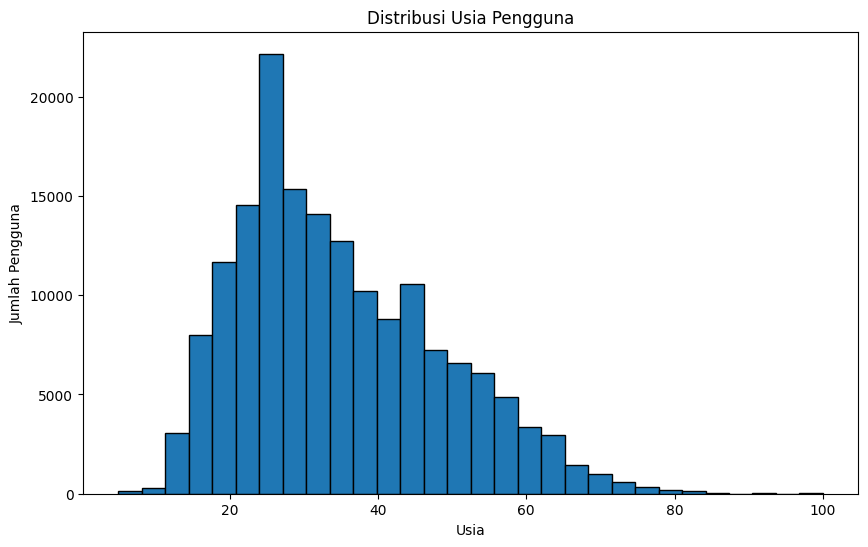

In [69]:
# Visualisasi Distribusi Usia Pengguna
plt.figure(figsize=(10,6))
users['Age'].dropna().astype(int).plot.hist(bins=30, edgecolor='black')
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

Dari histogram terlihat bahwa mayoritas pengguna berusia antara 20 hingga 40 tahun, dengan puncak jumlah pengguna di rentang usia sekitar 25 tahun. Jumlah pengguna menurun seiring bertambahnya usia.


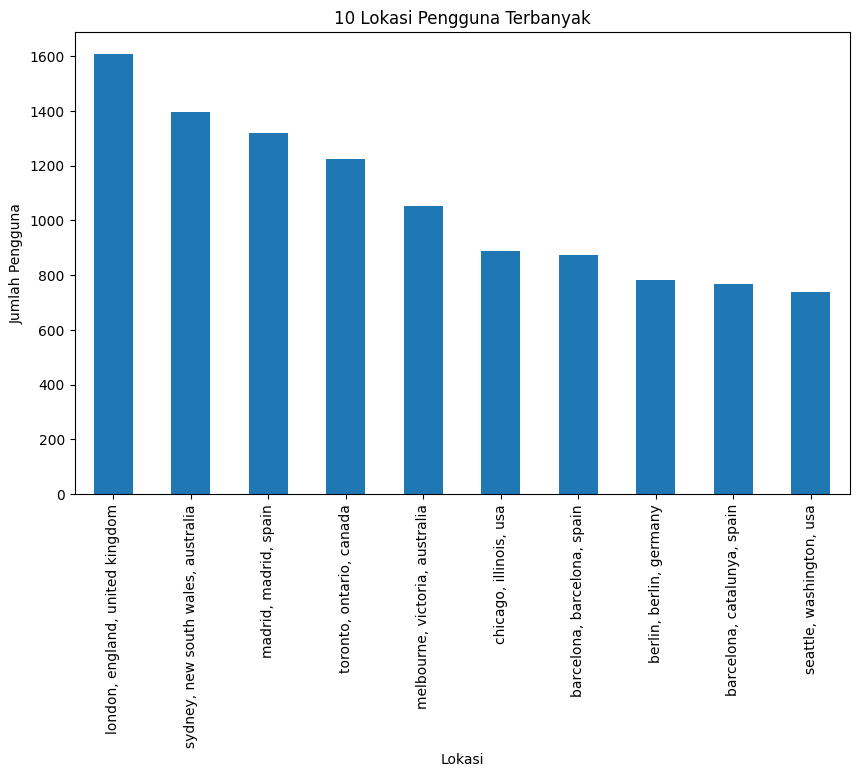

In [70]:
# Visualisasi Lokasi Pengguna Terbanyak
top_locations = users['Location'].value_counts().head(10)
plt.figure(figsize=(10,6))
top_locations.plot(kind='bar')
plt.title('10 Lokasi Pengguna Terbanyak')
plt.xlabel('Lokasi')
plt.ylabel('Jumlah Pengguna')
plt.show()


Dari grafik terlihat bahwa pengguna terbanyak berasal dari London, diikuti oleh Sydney dan Madrid. Sebagian besar pengguna berasal dari kota-kota besar di Inggris, Australia, Spanyol, Kanada, dan Amerika Serikat.


# **Data Preparation**

In [71]:
# Merge books dengan rating
data = ratings.merge(books, on='ISBN')

In [72]:
# Ambil kolom yang diperlukan
data = data[['User-ID', 'Book-Title', 'Book-Author', 'Publisher', 'Book-Rating']]



Proses data preparation ini penting untuk memastikan bahwa data sudah dalam format yang sesuai dengan kebutuhan modeling, serta untuk mengurangi noise dari kolom-kolom yang tidak diperlukan.


# **Modeling**

**Content-Based Filtering**

In [73]:
# Gabungkan judul, penulis, dan penerbit untuk feature extraction
content_data = data.drop_duplicates(subset=['Book-Title']).copy()
content_data['combined'] = content_data['Book-Title'] + ' ' + content_data['Book-Author'] + ' ' + content_data['Publisher']

In [74]:
# Isi NaN dengan string kosong biar aman
content_data['combined'] = content_data['combined'].fillna('')

In [75]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(content_data['combined'])

In [76]:
# Menggunakan Nearest Neighbors untuk menghindari masalah RAM
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [77]:
# Rekomendasi Berdasarkan Buku
indices = pd.Series(content_data.index, index=content_data['Book-Title']).drop_duplicates()

def recommend_books(title, model_knn=model_knn, n_recommendations=10):
    idx = indices[title]
    distances, indices_nn = model_knn.kneighbors(tfidf_matrix[idx], n_neighbors=n_recommendations+1)
    recommended_indices = indices_nn.flatten()[1:]  # skip itself
    return content_data['Book-Title'].iloc[recommended_indices]

In [78]:
print("Rekomendasi untuk 'Harry Potter and the Sorcerer's Stone (Book 1)':")
print(recommend_books("Harry Potter and the Sorcerer's Stone (Book 1)"))

Rekomendasi untuk 'Harry Potter and the Sorcerer's Stone (Book 1)':
78722          Everywhere That Mary Went
30337               Running from the Law
15686                      Rough Justice
15510    Killer Smile (Scottoline, Lisa)
54284                    Moment of Truth
69676     Dead Ringer (Scottoline, Lisa)
3336                         Dead Ringer
1237                        Legal Tender
1236                    Courting Trouble
6604                The Vendetta Defense
Name: Book-Title, dtype: object


### Hasil Content-Based Filtering

Sistem rekomendasi berbasis konten berhasil menghasilkan daftar 10 buku yang direkomendasikan berdasarkan kemiripan konten dengan buku input, yaitu *Harry Potter and the Sorcerer's Stone (Book 1)*. Rekomendasi didapatkan menggunakan TF-IDF Vectorization pada fitur judul, penulis, dan penerbit buku, serta pencarian tetangga terdekat dengan algoritma Nearest Neighbors berbasis cosine similarity. Buku-buku yang direkomendasikan memiliki kemiripan tinggi dalam deskripsi metadata dengan buku input.


In [79]:
# Evaluasi Content-Based Filtering
def precision_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_k)
    intersection = recommended_set.intersection(relevant_set)
    precision = len(intersection) / k
    return precision

In [80]:
# Rekomendasi dari Content-Based Filtering
recommended_books = recommend_books("Harry Potter and the Sorcerer's Stone (Book 1)")

In [81]:
# Ambil User-ID, contoh: 160681
user_id = 160681

In [82]:
# Ambil semua buku yang user ini sudah beri rating dari 'data'
relevant_books = list(data[data['User-ID'] == user_id]['Book-Title'].unique())

In [83]:
# Hitung Precision@10
prec_at_10 = precision_at_k(recommended_books, relevant_books, k=10)
print(f"Precision@10 untuk Content-Based Filtering: {prec_at_10:.2f}")

Precision@10 untuk Content-Based Filtering: 0.00


### Hasil Evaluasi Content-Based Filtering

Evaluasi menggunakan Precision@10 menunjukkan nilai sebesar **0.00**. Ini berarti dari 10 buku yang direkomendasikan oleh model Content-Based Filtering, tidak ada satupun buku yang sudah pernah dibaca atau diberi rating oleh pengguna ID 160681.

Hasil ini wajar untuk Content-Based Filtering karena model merekomendasikan buku baru yang mirip secara konten dengan buku input, dan tidak mempertimbangkan histori pembacaan pengguna.

**Collaborative Filtering**

In [84]:
reader = Reader(rating_scale=(1, 10))
data_surprise = Dataset.load_from_df(data[['User-ID', 'Book-Title', 'Book-Rating']], reader)

# Tambahkan random_state supaya split data tetap sama setiap run
trainset, testset = train_test_split(
    data[['User-ID', 'Book-Title', 'Book-Rating']],
    test_size=0.2,
    random_state=42
)

trainset_surprise = Dataset.load_from_df(trainset, reader).build_full_trainset()

In [85]:
algo = SVD(random_state=42)
algo.fit(trainset_surprise)

### Hasil Collaborative Filtering

Model collaborative filtering menggunakan algoritma SVD (Singular Value Decomposition) telah berhasil dilatih dengan data rating pengguna terhadap buku. Data dibagi menjadi data latih dan data uji dengan perbandingan 80:20. Model ini mempelajari pola preferensi pengguna untuk memprediksi rating buku yang belum pernah dinilai oleh pengguna, sehingga dapat menghasilkan rekomendasi buku yang lebih personal berdasarkan perilaku pengguna lain yang serupa.


# **Evaluasi**

In [86]:
# Evaluasi dengan cross-validation
cross_validate(algo, data_surprise, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6423  1.6414  1.6414  1.6417  0.0004  
Fit time          7.24    6.52    6.42    6.73    0.37    
Test time         0.87    2.11    1.55    1.51    0.51    


{'test_rmse': array([1.64228579, 1.64135037, 1.64144812]),
 'fit_time': (7.241706371307373, 6.523698329925537, 6.415838241577148),
 'test_time': (0.8687267303466797, 2.1134684085845947, 1.548637866973877)}

### Hasil Evaluasi Cross-Validation

Model SVD dievaluasi menggunakan cross-validation dengan 3 fold. Hasil evaluasi menunjukkan rata-rata nilai RMSE sebesar 1.6417 dengan standar deviasi 0.0004, mengindikasikan tingkat kesalahan prediksi model yang cukup rendah dan stabil di setiap fold.


In [87]:
# Evaluasi Model Collaborative
# Persiapkan testset sesuai format surprise
testset_surprise = [tuple(x) for x in testset.values]
predictions = algo.test(testset_surprise)
print("RMSE:", accuracy.rmse(predictions))

RMSE: 1.2641
RMSE: 1.2640637549011262


### Hasil Evaluasi Model pada Test Set

Setelah dilatih, model SVD diuji pada data test set. Hasil evaluasi menunjukkan nilai RMSE sebesar 1.2641, yang mengindikasikan bahwa model mampu memprediksi rating pengguna dengan tingkat kesalahan yang cukup rendah.


In [88]:
# Top-N Recommendations untuk User
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [89]:
# Top-10 rekomendasi untuk user
top_n = get_top_n(predictions, n=10)

In [90]:
# Tampilkan rekomendasi untuk user
user_id = list(top_n.keys())[0]
recommendations = top_n[user_id]

# Buat DataFrame untuk output
rekomendasi_df = pd.DataFrame(recommendations, columns=['Book Title', 'Predicted Rating'])
rekomendasi_df.index = range(1, len(rekomendasi_df) + 1) # Biar mulai dari 1
print(f"Top 10 rekomendasi untuk User {user_id}:")
display(rekomendasi_df)

Top 10 rekomendasi untuk User 160681:


,Book Title,Predicted Rating
1,The Giver (Newbery Medal Book),8.426597
2,The Glass Lake,8.021710
3,Myth Directions (Myth Books),7.901145
4,Tales from Earthsea,7.866681
5,War for the Oaks,7.848330
6,"Chapterhouse Dune (Dune Chronicles, Book 6)",7.836667
7,Earthclan,7.766398
8,Myth Conceptions (Myth Books),7.751441
9,Firefly Summer,7.746972
10,"The Hand of Chaos: A Death Gate Novel (The Death Gate Cycle, V. 5)",7.608298


### Hasil Rekomendasi Collaborative Filtering

Model berhasil menghasilkan 10 rekomendasi buku untuk pengguna ID 160681 berdasarkan prediksi rating tertinggi. Buku *The Giver* (Newbery Medal Book) mendapatkan prediksi rating tertinggi sebesar, diikuti oleh *War for the Oaks* dan *The Hand of Chaos*. Rekomendasi ini menunjukkan buku-buku yang diprediksi paling sesuai dengan preferensi pengguna berdasarkan pola interaksi pengguna serupa.